# Step 1 :  Dataset Preparartion

## Importing libraries

In [2]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import random
import joblib
import sys, os, distutils.core
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

#print(torch.__version__)
#print(cv2.__version__)

## Check for gpu or cpu  available

In [3]:
# GPU is used for faster processing.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Cloning and Installing  Detctron2

In [4]:
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python3 -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

fatal: destination path 'detectron2' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable


## Load Dataset

In [5]:
# extract files
#!unzip -d 'path/to/target/directory' 'path/to/source/directory'

!unzip -d  '../data/processed_data'    '../data/processed_data/dataset.zip'

Archive:  ../data/processed_data/dataset.zip
  inflating: ../data/processed_data/data/drive/drives1.png  
  inflating: ../data/processed_data/data/drive/drives10.png  
  inflating: ../data/processed_data/data/drive/drives100.png  
  inflating: ../data/processed_data/data/drive/drives1000.png  
  inflating: ../data/processed_data/data/drive/drives1001.png  
  inflating: ../data/processed_data/data/drive/drives1002.jpeg  
  inflating: ../data/processed_data/data/drive/drives1003.png  
  inflating: ../data/processed_data/data/drive/drives1004.png  
  inflating: ../data/processed_data/data/drive/drives1005.png  
  inflating: ../data/processed_data/data/drive/drives1006.png  
  inflating: ../data/processed_data/data/drive/drives1007.png  
  inflating: ../data/processed_data/data/drive/drives1008.jpeg  
  inflating: ../data/processed_data/data/drive/drives1009.png  
  inflating: ../data/processed_data/data/drive/drives101.png  
  inflating: ../data/processed_data/data/drive/drives1010.png  


In [6]:
# specify path for images
path='../data/processed_data/data/'

# list down the folders 
folders = os.listdir(path)
folders.sort()

print(f'Shots in a Dataset : {folders}')

Shots in a Dataset : ['drive', 'legglance-flick', 'pullshot', 'sweep']


In [7]:
# create lists of cleaned images
images  = []
labels  = []

# for each folder
for folder in folders:
    # list down image names
    names=os.listdir(path+folder)
    # for each image
    for name in names:
        # read an image
        img=cv2.imread(path+folder+'/'+name)
        # append image to list
        images.append(img)       
        # append folder name (type of shot) to list
        labels.append(folder)

# number of images
print(len(images))

4724


## Showing Some Images Form Dataset

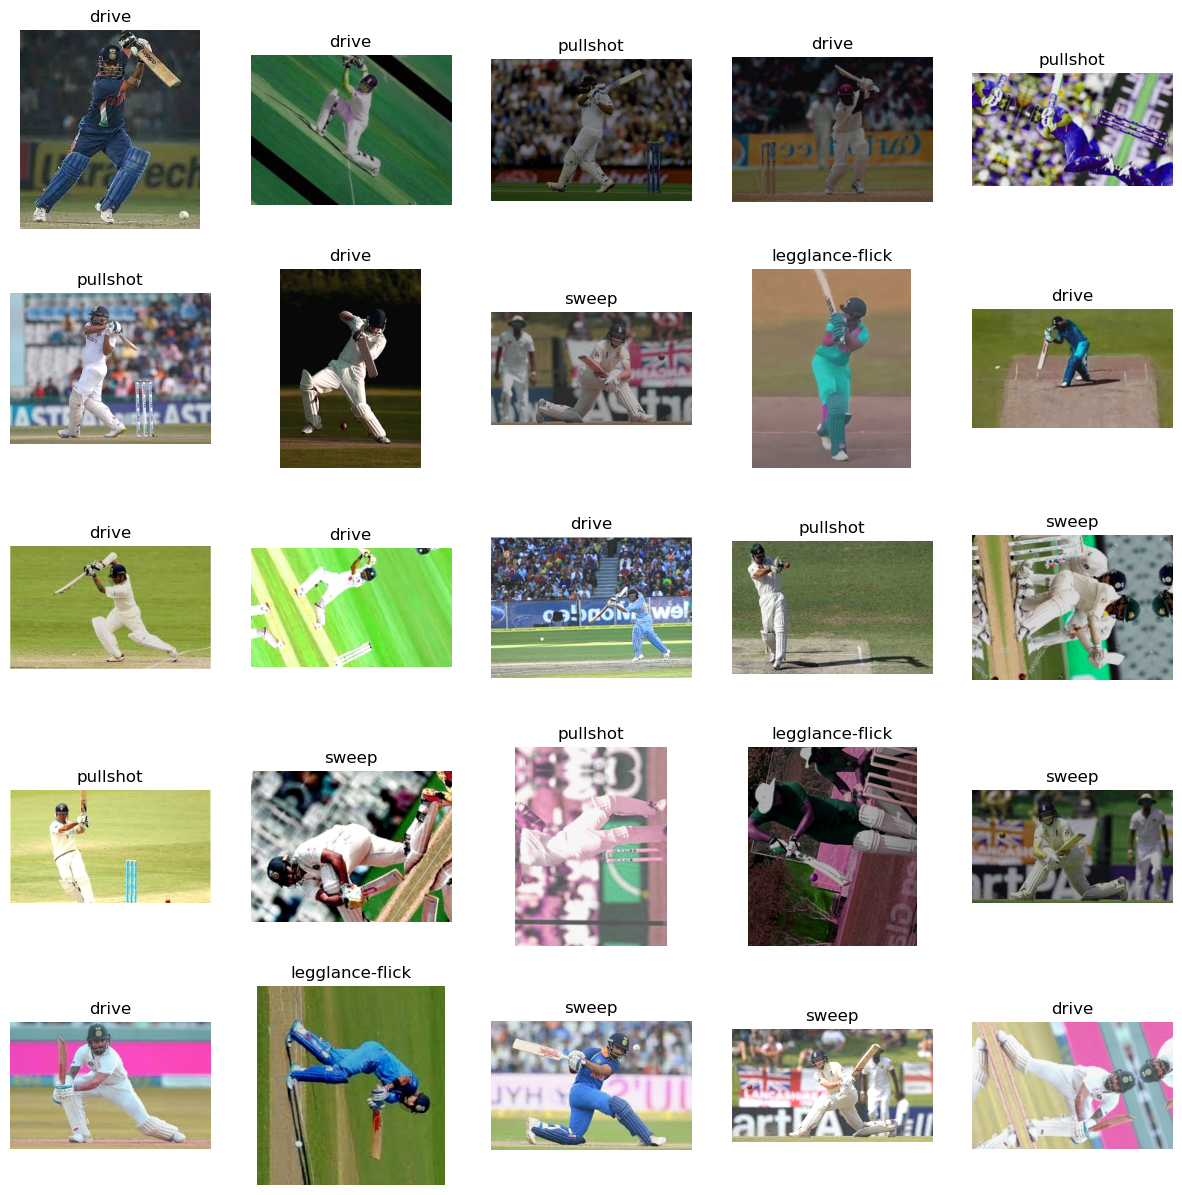

In [8]:
# create subplots with 5 rows and 5 columns
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

# randomly sample indices
ind = random.sample(range(len(images)), 25)

for row in range(5):
  for col in range(5): 
      img_idx = 5 * row + col  # Calculate the index for the ind list
      img = cv2.cvtColor(images[ ind[img_idx] ], cv2.COLOR_BGR2RGB)
      ax[row, col].imshow(img)
      # set title
      ax[row, col].set_title(labels[ ind[img_idx] ])
      # Turn off axis
      ax[row, col].axis('off')

# Step 2 : Data Augmentation

- To increase our training size so we’ll flip the images horizontally and this will help us with two things first of all the players can be both right-handed and left-handed so by flipping the images. It will make our model more generalized. It will also increase the number of images for training.

- The above Data is already augmented before going to train model. To Know how it is done, see the Data_Augmentation.ipynb notebook.



# Step 3 : KeyPoints Extraction using detectron2 

In [9]:
# import some common detectron2 utilities to obtain pretrained models
from detectron2 import model_zoo
# set up predictor
from detectron2.engine import DefaultPredictor
# set config
from detectron2.config import get_cfg
# define configure instance
cfg = get_cfg()

#select cpu if gpu is not available
cfg.MODEL.DEVICE = 'cpu'

# get a model specified by relative path under Detectron2’s official configs/ directory.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))

#pretrained model 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")

# set threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8

# create predictor
predictor = DefaultPredictor(cfg)

## Draw KeyPoints and Box on Some Images

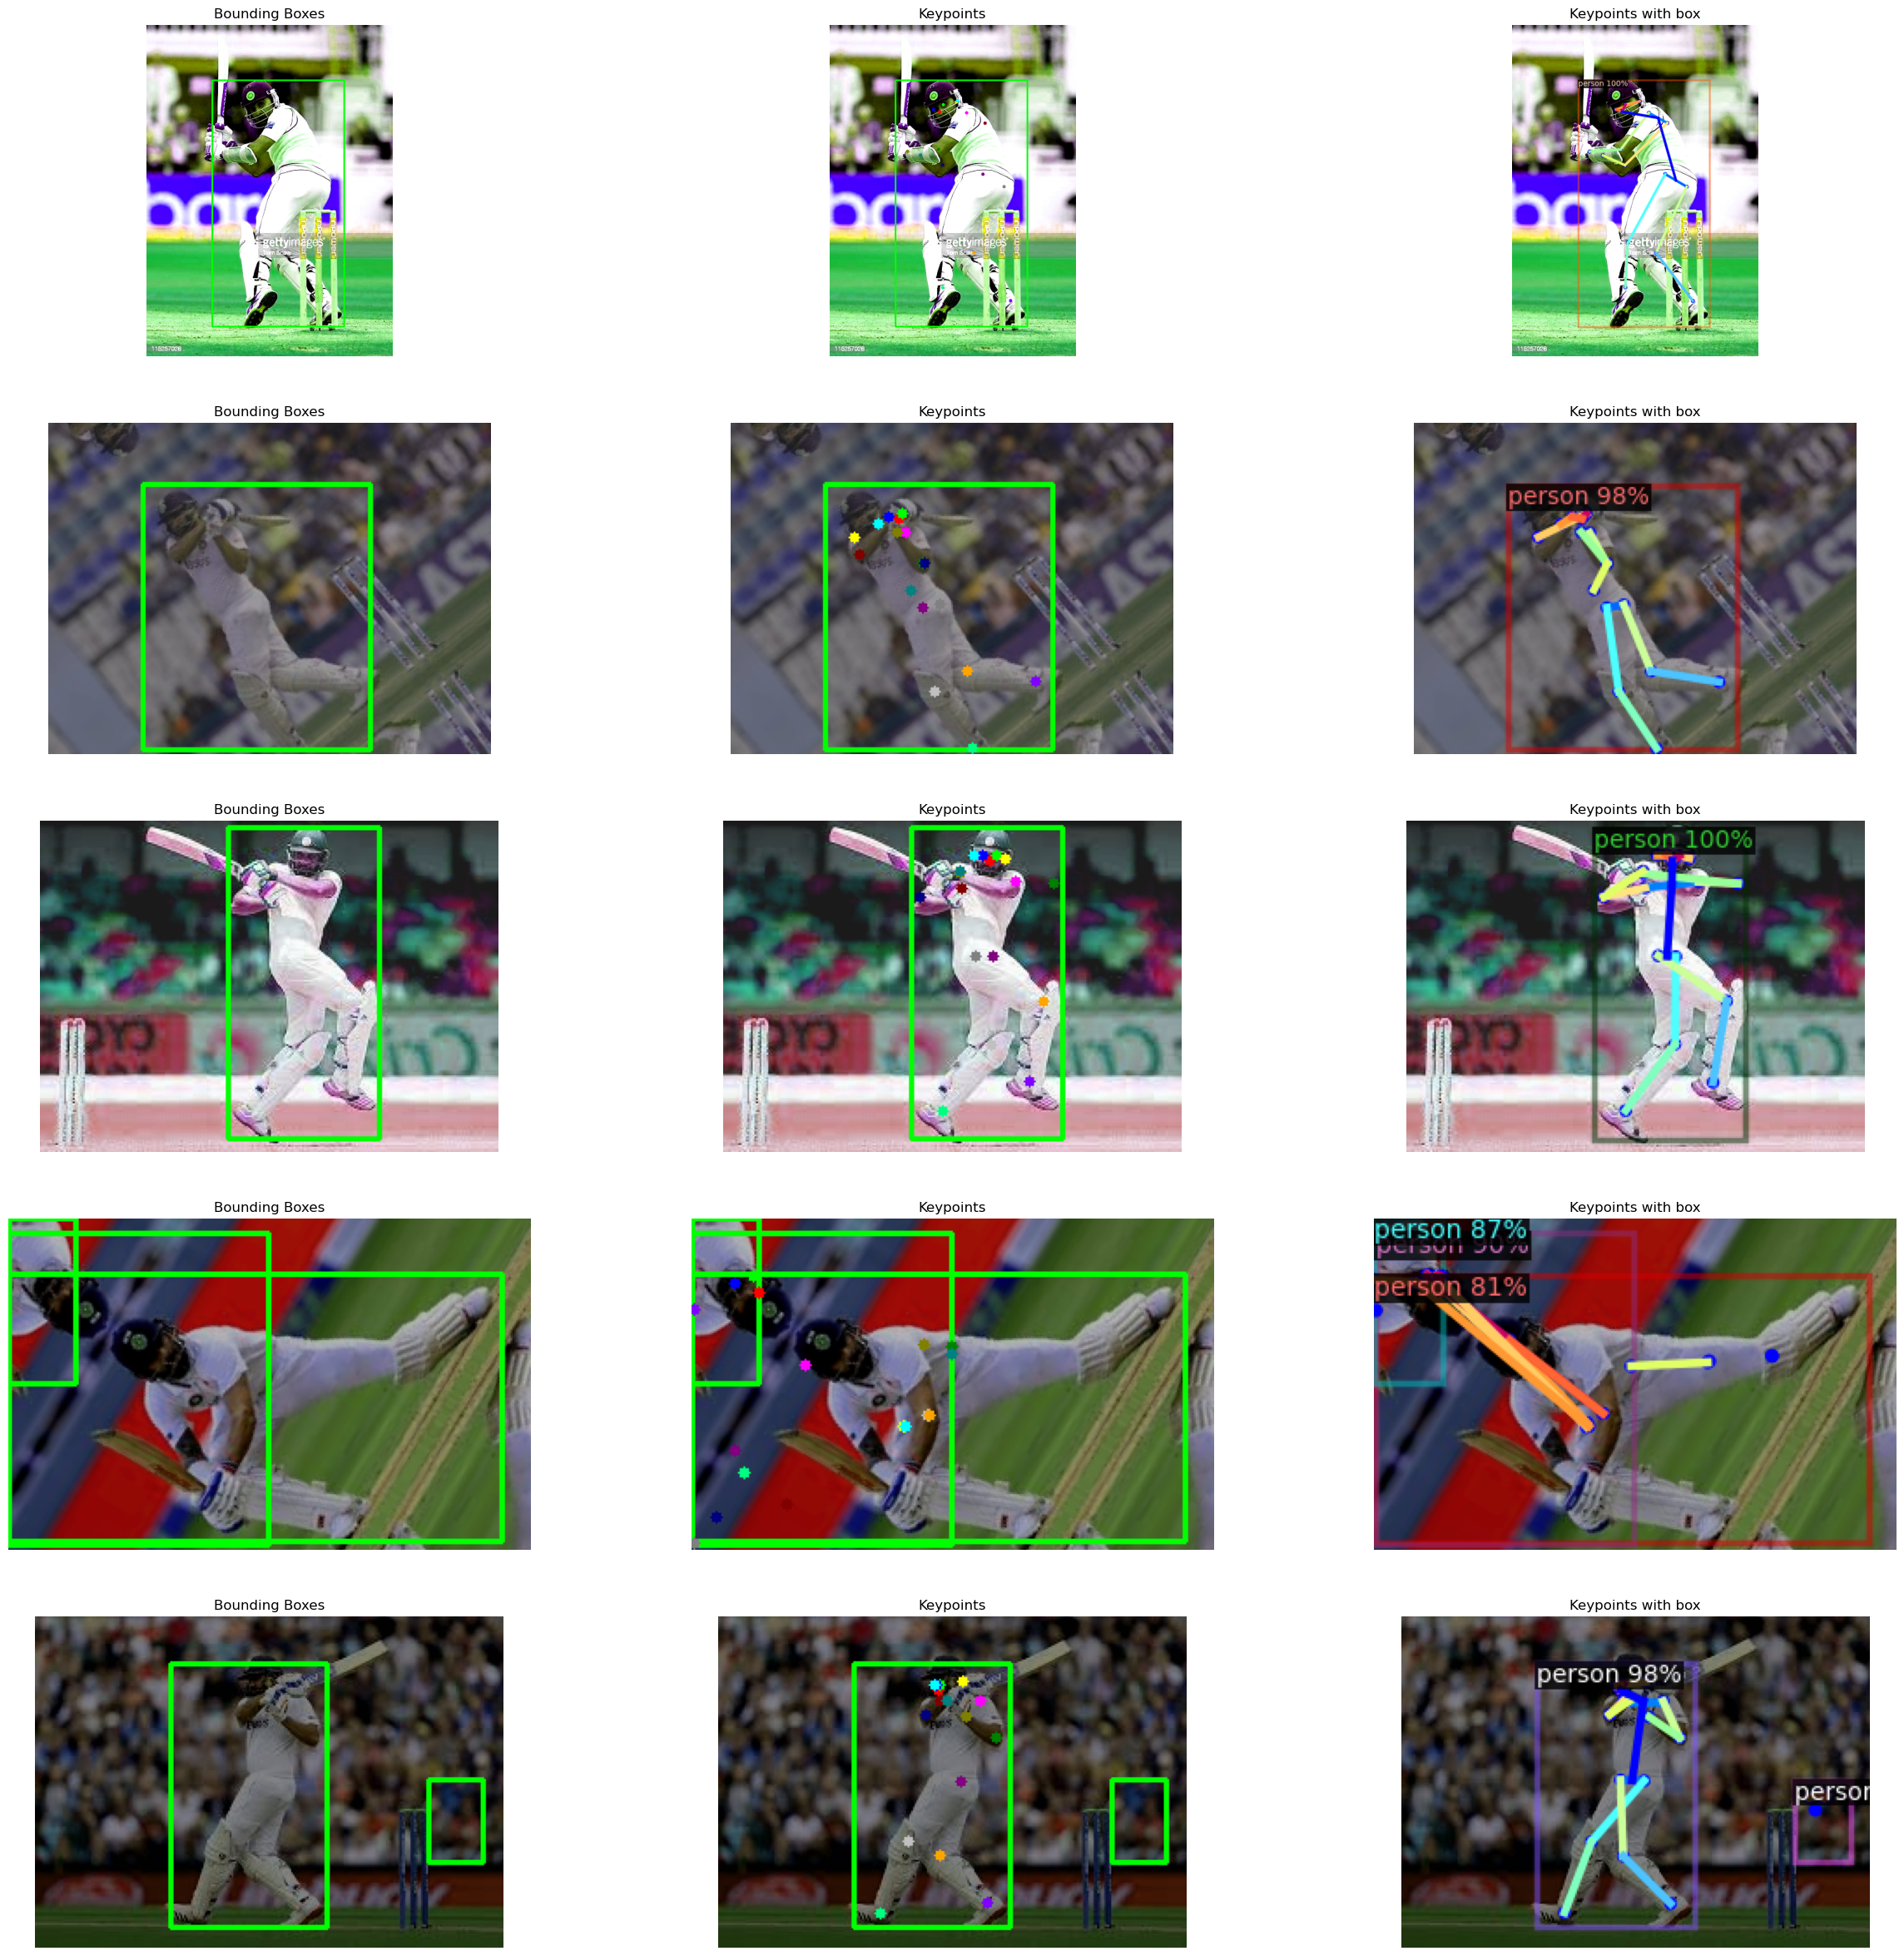

In [12]:
# for drawing predictions on images
from detectron2.utils.visualizer import Visualizer

# to obtain metadata
from detectron2.data import MetadataCatalog

fig, ax = plt.subplots(ncols=3,nrows=5 ,figsize=(30,30))

# randomly select images
for i,img in enumerate(random.sample(images,5)):    
    # make predictions
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    outputs = predictor(img)
    #print(outputs)
    
    # find the objects in image
    num_instances = len(outputs['instances'])
    
    #print(num_instances)
    if(num_instances == 0):
        # If no instances were detected, display the original image
        img_with_bboxes = img_with_keypoints= img.copy()
        ax[i,2].imshow(img)
        ax[i,2].set_title("Failed to Detect")
        ax[i,2].axis("off")
        
    else:
        # use `Visualizer` to draw the predictions on the image.
        v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)

        # Extract bounding boxes from the output
        pred_boxes = outputs["instances"].pred_boxes.to("cpu").tensor.numpy()

        # Draw bounding boxes
        img_with_bboxes = img.copy()
        for box in pred_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_with_bboxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Draw keypoints on the image
        pred_keypoints = outputs["instances"].pred_keypoints.cpu().numpy()

        # Define colors for each keypoint
        colors = [
                (255, 0, 0),  # Keypoint 1 (red)
                (0, 255, 0),  # Keypoint 2 (green)
                (0, 0, 255),  # Keypoint 3 (blue)
                (255, 255, 0),  # Keypoint 4 (yellow)
                (0, 255, 255),  # Keypoint 5 (cyan)
                (255, 0, 255),  # Keypoint 6 (magenta)
                (128, 0, 0),  # Keypoint 7 (maroon)
                (0, 128, 0),  # Keypoint 8 (green)
                (0, 0, 128),  # Keypoint 9 (navy)
                (128, 128, 0),  # Keypoint 10 (olive)
                (0, 128, 128),  # Keypoint 11 (teal)
                (128, 0, 128),  # Keypoint 12 (purple)
                (128, 128, 128),  # Keypoint 13 (gray)
                (192, 192, 192),  # Keypoint 14 (silver)
                (255, 165, 0),  # Keypoint 15 (orange)
                (0, 255, 128),  # Keypoint 16 (turquoise)
                (128, 0, 255),  # Keypoint 17 (violet)
        ]

        # Draw all keypoints with different colors
        img_with_keypoints = img_with_bboxes.copy()
        for idx, keypoint in enumerate(pred_keypoints[0]):
            x, y, conf = keypoint
            if conf > 0.0:  # Draw keypoints with confidence > 0
                color = colors[idx]
                cv2.circle(img_with_keypoints, (int(x), int(y)), 3, color, -1)

        # draw prediction on image
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        ax[i,2].imshow(v.get_image()[:, :, ::-1])
        ax[i,2].set_title("Keypoints with box")
        ax[i,2].axis("off")

    # display image
    ax[i,0].imshow(img_with_bboxes)
    ax[i,0].set_title("Bounding Boxes")
    ax[i,0].axis("off")
    
    ax[i,1].imshow(img_with_keypoints)
    ax[i,1].set_title("Keypoints")
    ax[i,1].axis("off")

## Extract KeyPoints For Each Image

In [14]:
# define function that extracts the keypoints for an image
def extract_keypoints(img):  
  
    # make predictions
  outputs = predictor(img)
  # fetch keypoints
  keypoints = outputs['instances'].pred_keypoints
  # convert to numpy array
  kp = keypoints.cpu().numpy()
  # if keypoints detected
  if(len(keypoints)>0):
    # fetch keypoints of a person with maximum confidence score
    kp = kp[0]
    kp = np.delete(kp,2,1)
    # convert 2D array to 1D array
    kp = kp.flatten()
    # return keypoints
    return kp

In [15]:
#Extract keypoints

# progress bar
from tqdm import tqdm

# create list
keypoints   = []

for i in tqdm(range(len(images))): 
  # extract keypoints
  kp = extract_keypoints(images[i]) 
  # append keypoints 
  keypoints.append(kp)

100%|█████████████████████████████████████| 4724/4724 [3:59:00<00:00,  3.04s/it]


In [16]:
keypoints2 = keypoints.copy()

## Remove Images on Which Keypoints are not Detetected

In [ ]:
# Finding the index of images on which keypoints is not detected.
b=[]
for i in range(len(keypoints)):
    if(keypoints[i] is None):
        b.append(i)
print(b)

In [ ]:
# Delete that images and labels
indices=b.copy()
for i in sorted(indices, reverse=True):
    del keypoints[i]
    del labels[i]
    del images[i]
    
#Remaining keypoints
print(len(keypoints))

# Step 4 : Dataset Normalizaton and Label Encoding

## Normalize keypoints

In [21]:
# define normalizer
scaler= StandardScaler()

# normalize keypoints
keypoints = scaler.fit_transform(keypoints)
keypoints = np.array(keypoints)

## Save Scaler Model For Use in Prediction

In [22]:
# Specify the full path to the directory and the file name
directory_path = '../models/trained_model'
file_name = 'scaler.pkl'

# Save the model to the specified directory
joblib.dump(scaler, f'{directory_path}/{file_name}')

['../models/trained_model/scaler.pkl']

## Encoding Categorical Variable

In [23]:
le = LabelEncoder()
y=le.fit_transform(labels)

#Show Label
print(y)

[0 0 0 ... 3 3 3]


## Mapping Between Label and Thier Corresponding Category

In [24]:
#get original labels
original_labels = le.inverse_transform(y)

# Printing the label corresponds to which number
for label, number in zip(original_labels, y):
    print(f"{label} --> {number}")

drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
drive --> 0
driv

# Step 5 : Train And Test Split

In [25]:
# split keypoints and labels in 80:20
x_tr, x_val, y_tr, y_val = train_test_split(keypoints, y, test_size=0.2, stratify=labels, random_state=120)

## Converting The Keypoints and Target value to Tensor

In [26]:
x_tr = torch.Tensor(x_tr)
x_val = torch.Tensor(x_val)
y_tr = torch.Tensor(y_tr)
y_tr = y_tr.type(torch.long)
y_val = torch.Tensor(y_val)
y_val = y_val.type(torch.long)

## Shape of Training and Validation Set

In [27]:
(x_tr.shape, y_tr.shape), (x_val.shape, y_val.shape)

((torch.Size([3168, 34]), torch.Size([3168])),
 (torch.Size([793, 34]), torch.Size([793])))

# Step 6 : Model Architecture and Training

## Defining The Architecture of ANN Model

In [490]:
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear, ReLU, Sequential, Softmax, CrossEntropyLoss,LeakyReLU

# defining the model architecture
model = Sequential(Linear(34, 128), 
                    ReLU(),
                    Linear(128, 256),  
                    ReLU(),
                    Linear(256, 256), 
                    LeakyReLU(0.01),
                    Linear(256, 4),
                    Softmax()
                   )

#Model Summary
print(model)

Sequential(
  (0): Linear(in_features=34, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=256, out_features=4, bias=True)
  (7): Softmax(dim=None)
)


## Define Optimizer and Loss Function

In [491]:
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

## Train a ANN Model 

In [492]:
#Creating Function To Train a Model
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(x_tr), Variable(y_tr)
    # getting the validation set
    x_valid, y_valid = Variable(x_val), Variable(y_val)

    
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_valid = x_valid.cuda()
        y_valid = y_valid.cuda()
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_valid)
    
    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_valid)
    
    #save train and val loss for futher visualization
    training_losses.append(loss_train.item())
    validation_losses.append(loss_val.item())
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    if epoch%5 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, 't', 'loss :', loss_val.item())

In [493]:
# For store train and val loss
training_losses = []
validation_losses = []

# Defining the number of epochs
n_epochs = 120
# Training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 t loss : 1.3862340450286865
Epoch :  6 t loss : 1.3064005374908447
Epoch :  11 t loss : 1.134194254875183
Epoch :  16 t loss : 1.082996129989624
Epoch :  21 t loss : 1.0516741275787354
Epoch :  26 t loss : 1.0313016176223755
Epoch :  31 t loss : 1.0077056884765625
Epoch :  36 t loss : 0.9895796775817871
Epoch :  41 t loss : 0.9723681807518005
Epoch :  46 t loss : 0.9527333974838257
Epoch :  51 t loss : 0.9537808299064636
Epoch :  56 t loss : 0.9428669214248657
Epoch :  61 t loss : 0.9298988580703735
Epoch :  66 t loss : 0.9193453192710876
Epoch :  71 t loss : 0.9127759337425232
Epoch :  76 t loss : 0.9113478660583496
Epoch :  81 t loss : 0.9080326557159424
Epoch :  86 t loss : 0.9108628630638123
Epoch :  91 t loss : 0.944207489490509
Epoch :  96 t loss : 0.9245268106460571
Epoch :  101 t loss : 0.9116317629814148
Epoch :  106 t loss : 0.9096697568893433
Epoch :  111 t loss : 0.9050500988960266
Epoch :  116 t loss : 0.8979877829551697


## Save Model

In [494]:
# Specify the full path to the directory and the file name
directory_path = '../models/trained_model'
file_name = 'model.pth'

# Save the model to the specified directory
torch.save(model, f'{directory_path}/{file_name}')

# Step 7 : Model Evaluation 

## Monitoring Training and Validation Error

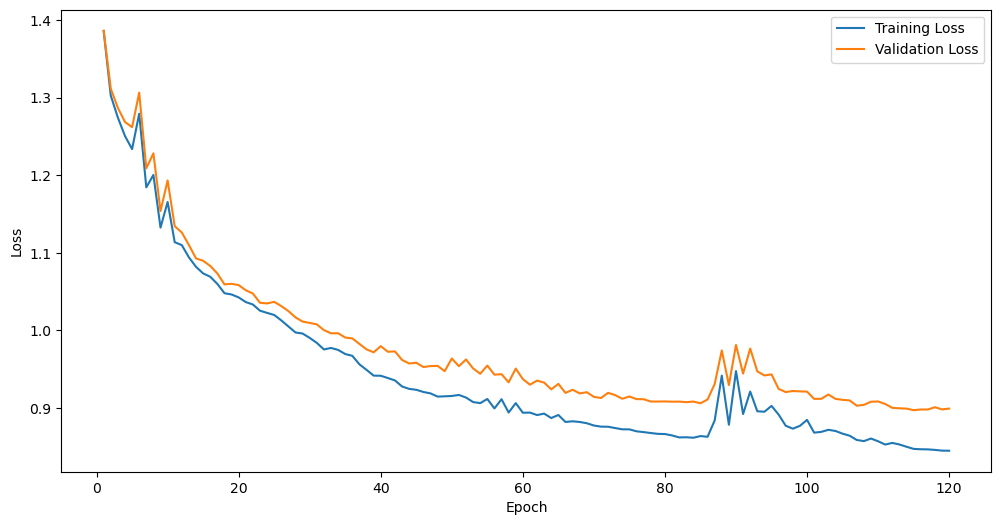

In [495]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epoch + 2), training_losses, label='Training Loss')
plt.plot(range(1, epoch + 2), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Performance Evaluation Metric

In [496]:
# To check the model performance
x_tr, y_tr = Variable(x_tr), Variable(y_tr)
x_val, y_val = Variable(x_val), Variable(y_val)

if torch.cuda.is_available():
  x_tr = x_tr.cuda()
  y_tr = y_tr.cuda()
  x_val = x_val.cuda()
  y_val = y_val.cuda()

# Train set Accuracy
train_pred = model(x_tr)
final_train_pred = np.argmax(train_pred.cpu().data.numpy(), axis=1)
train_accuracy = accuracy_score(y_tr.cpu(), final_train_pred)

# Test set Accuracy 
test_pred = model(x_val)
final_test_pred = np.argmax(test_pred.cpu().data.numpy(), axis=1)
test_accuracy =accuracy_score(y_val.cpu(), final_test_pred)

print(f"Training Accuracy   : {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy : {test_accuracy * 100:.2f}%")

Training Accuracy   : 90.25%
Validation Accuracy : 83.98%


## Plot Confusion Matrix

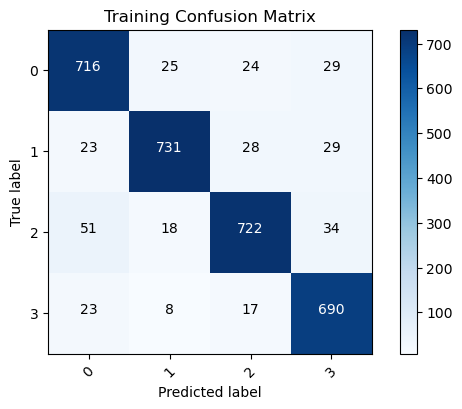

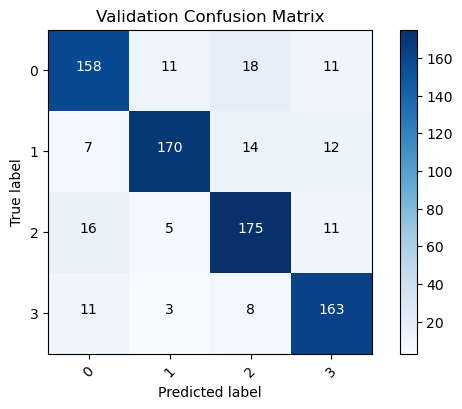

In [497]:
confusion_matrix_train = confusion_matrix(y_tr, final_train_pred)
confusion_matrix_valid = confusion_matrix(y_val, final_test_pred)

# Define a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

# Plot confusion matrix for training data
plt.figure(figsize=(6, 4))
plot_confusion_matrix(confusion_matrix_train, classes=range(4), title='Training Confusion Matrix')
plt.show()

# Plot confusion matrix for validation data
plt.figure(figsize=(6, 4))
plot_confusion_matrix(confusion_matrix_valid, classes=range(4), title='Validation Confusion Matrix')
plt.show()


## Classification Report

In [498]:
# Generate the classification report
train_report = classification_report(y_tr, final_train_pred)
test_report = classification_report(y_val, final_test_pred)

# Print the report
print(f"Classification Report for training set :\n {train_report}")
print(f"\nClassification Report for test set :\n {test_report}")

Classification Report for training set :
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       794
           1       0.93      0.90      0.92       811
           2       0.91      0.88      0.89       825
           3       0.88      0.93      0.91       738

    accuracy                           0.90      3168
   macro avg       0.90      0.90      0.90      3168
weighted avg       0.90      0.90      0.90      3168


Classification Report for test set :
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       198
           1       0.90      0.84      0.87       203
           2       0.81      0.85      0.83       207
           3       0.83      0.88      0.85       185

    accuracy                           0.84       793
   macro avg       0.84      0.84      0.84       793
weighted avg       0.84      0.84      0.84       793



# Step 8 : Prediction on new Data

## Create a Function for Prediction

In [499]:
def prediction(image):
    
    kpp= extract_keypoints(image)
    kpp = scaler.transform(kpp.reshape(1, -1))
    kpp = np.array(kpp)
    
    x_t = torch.Tensor(kpp)
    if torch.cuda.is_available():
            x_t = x_t.cuda()

    pred = model(x_t)
    pred = np.argmax(pred.cpu().data.numpy(), axis=1)
    
    shot_types = ['drive', 'legglance-flick', 'pullshot', 'sweep']
    
    predicted_shot = shot_types[pred[0]]
    
    return predicted_shot

## Plot Some Prediction

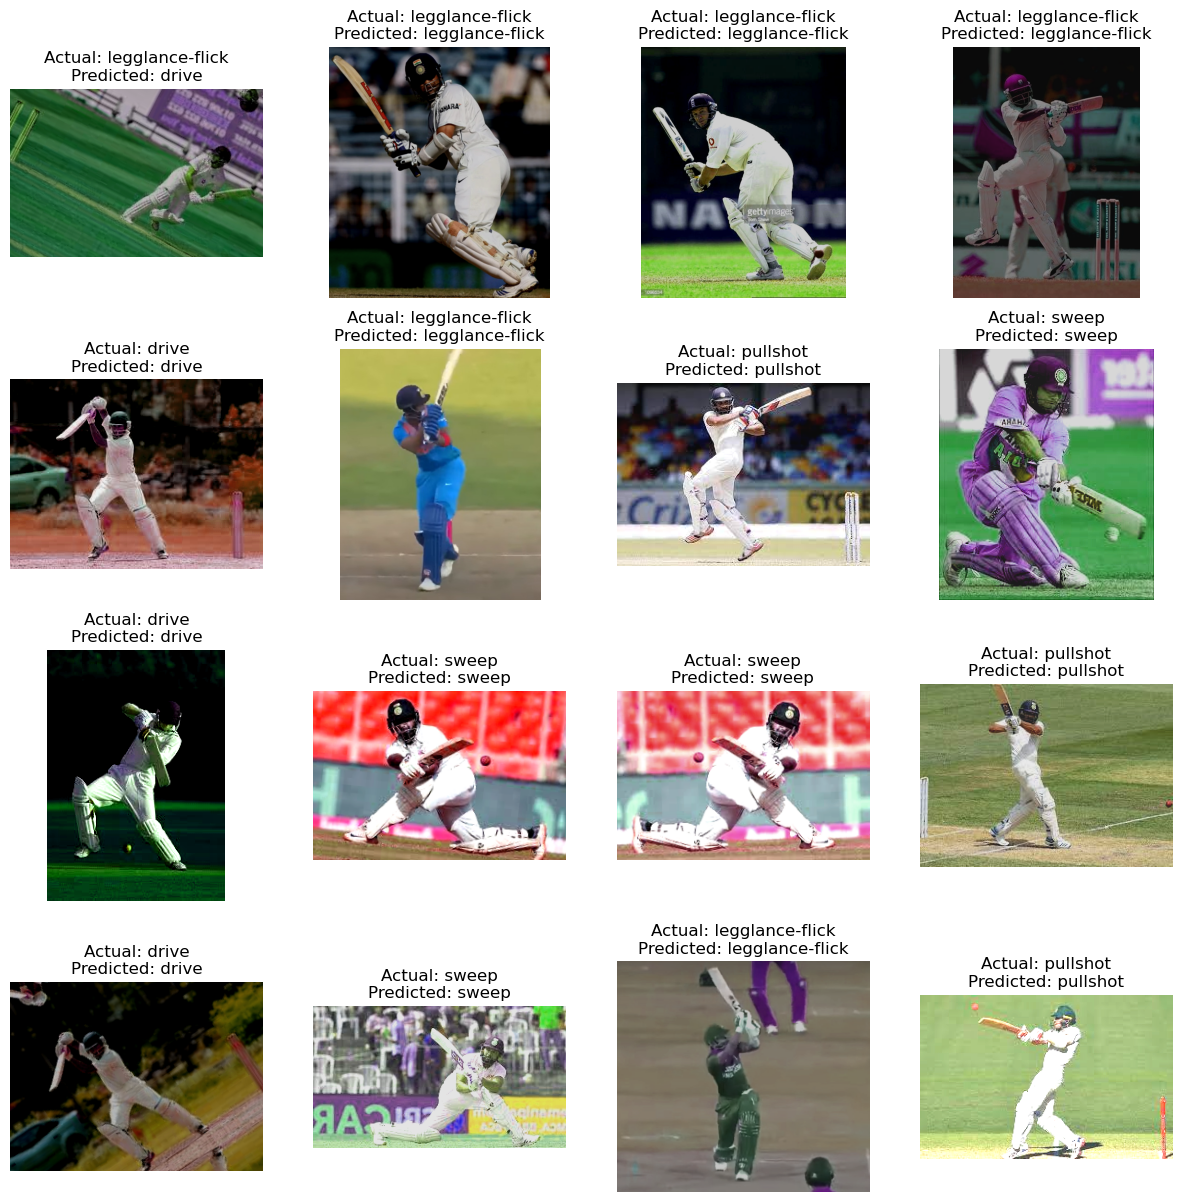

In [532]:
# create subplots with 4 rows and 4 columns
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,15))

# randomly sample indices
ind = random.sample(range(len(images)), 16)

for row in range(4):
  for col in range(4): 
      img_idx = 4 * row + col  # Calculate the index for the ind list
      img = cv2.cvtColor(images[ ind[img_idx] ], cv2.COLOR_BGR2RGB)
      actual_label = labels[ ind[img_idx] ]
      predicted_label = prediction(img)
      # display image
      ax[row, col].imshow(img)
      # set title
      ax[row, col].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
      # Turn off axis
      ax[row, col].axis('off')